## Application to CESM LENS Fields

In this notebook we pass the CESM LENS Temperature Sensitivity Anomalies Data through both an I2I model and a CNN model of choice. 

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import h5py

from latticevision.device import set_device
from latticevision.img2img import TransUNet, UNet, ViT
from latticevision.img2img.base import (
	ModelConfig,
	NullPosEmbed,
	LearnedPosEmbed,
	SinusoidalPosEmbed,
	RotaryPosEmbed,
)

from latticevision.cnn.model import ModelConfig as CNNModelConfig
from latticevision.cnn.model import CNN
from latticevision.cnn.eval import fast_cnn_field_tiler
from latticevision.seed import set_all_random_seeds

In [2]:
# fix random seed for reproducibility
set_all_random_seeds(777)

device = set_device(machine="remote", gpu_id="cuda:0", verbose=True)  # for remote use
# device = set_device(machine="local", gpu = False, verbose=True)  # for local use

Using device: cuda:0 
Hardware:  NVIDIA RTX A6000


Here we pull in the climate fields. 

In [3]:
file_path = "../data/CESM_LENS_fields.h5"
with h5py.File(file_path, "r") as f:
	print("Components in the file:", list(f.keys()))

	# extract components
	clim_fields = f["clim_fields"][:]
	clim_fields_norm = f["clim_fields_norm"][:]

	print("clim_fields shape:", clim_fields.shape)

Components in the file: ['clim_fields', 'clim_fields_norm']
clim_fields shape: (30, 192, 288)


In [4]:
# center in the pacific and add batch dimension
clim_fields_norm = np.roll(clim_fields_norm, shift=144, axis=-1)
clim_fields_norm = torch.tensor(clim_fields_norm).unsqueeze(0).float().to(device)
clim_fields_norm.shape

torch.Size([1, 30, 192, 288])

Pulling in our I2I model of choice: 

In [5]:
modeltype = "TransUNet"  # can also be "UNet, "ViT"
modelpath = "../results/model_wghts/modelTransUNet_reps30_posRotaryPosEmbed.pth"
n_reps = 30
pos_embeds = [NullPosEmbed, LearnedPosEmbed, SinusoidalPosEmbed, RotaryPosEmbed]

if modeltype == "UNet":
	config = ModelConfig(
		in_channels=n_reps,
	)
	model = UNet(config)
	model.load_state_dict(torch.load(modelpath))

elif modeltype == "TransUNet":
	config = ModelConfig(
		in_channels=n_reps,
		patch_size_h=2,
		patch_size_w=2,
		pos_embed_cls=pos_embeds[3],
	)
	model = TransUNet(config)
	model.load_state_dict(torch.load(modelpath))
elif modeltype == "ViT":
	config = ModelConfig(
		in_channels=n_reps,
		patch_size_h=16,
		patch_size_w=16,
		pos_embed_cls=pos_embeds[3],
	)
	model = ViT(config)
	model.load_state_dict(torch.load(modelpath))
else:
	raise ValueError("modeltype must be one of 'UNet', 'TransUNet', or 'ViT'")

model = model.to(device)
model.eval()

TransUNet(
  (encoders): ModuleList(
    (0): EncoderBlock(
      (conv): Sequential(
        (0): Conv2d(30, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (2): GELU(approximate='none')
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(8, 64, eps=1e-05, affine=True)
        (5): GELU(approximate='none')
      )
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (1): EncoderBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(16, 128, eps=1e-05, affine=True)
        (2): GELU(approximate='none')
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(16, 128, eps=1e-05, affine=True)
        (5): GELU(approximate='none')
      )
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2

We then pass the climate fields through the model and visualize the resulting parameters:

In [6]:
# Passing the climate fields through the model
output = model(clim_fields_norm[:, :n_reps, :, :])
print(output.shape)

kappa2 = np.flip(output[0, 0, :, :].detach().cpu().numpy(), axis=0)
theta = np.pi / 2 - np.flip(output[0, 1, :, :].detach().cpu().numpy(), axis=0)
rho = np.flip(output[0, 2, :, :].detach().cpu().numpy(), axis=0)
clim_field = np.flip(clim_fields_norm[0, 0, :, :].detach().cpu().numpy(), axis=0)
awght = np.exp(kappa2) + 4
print(
	np.min(awght), np.max(awght), np.min(theta), np.max(theta), np.min(rho), np.max(rho)
)

torch.Size([1, 3, 192, 288])
4.000635 4.2687354 0.53214586 2.4541829 0.9026282 3.898478


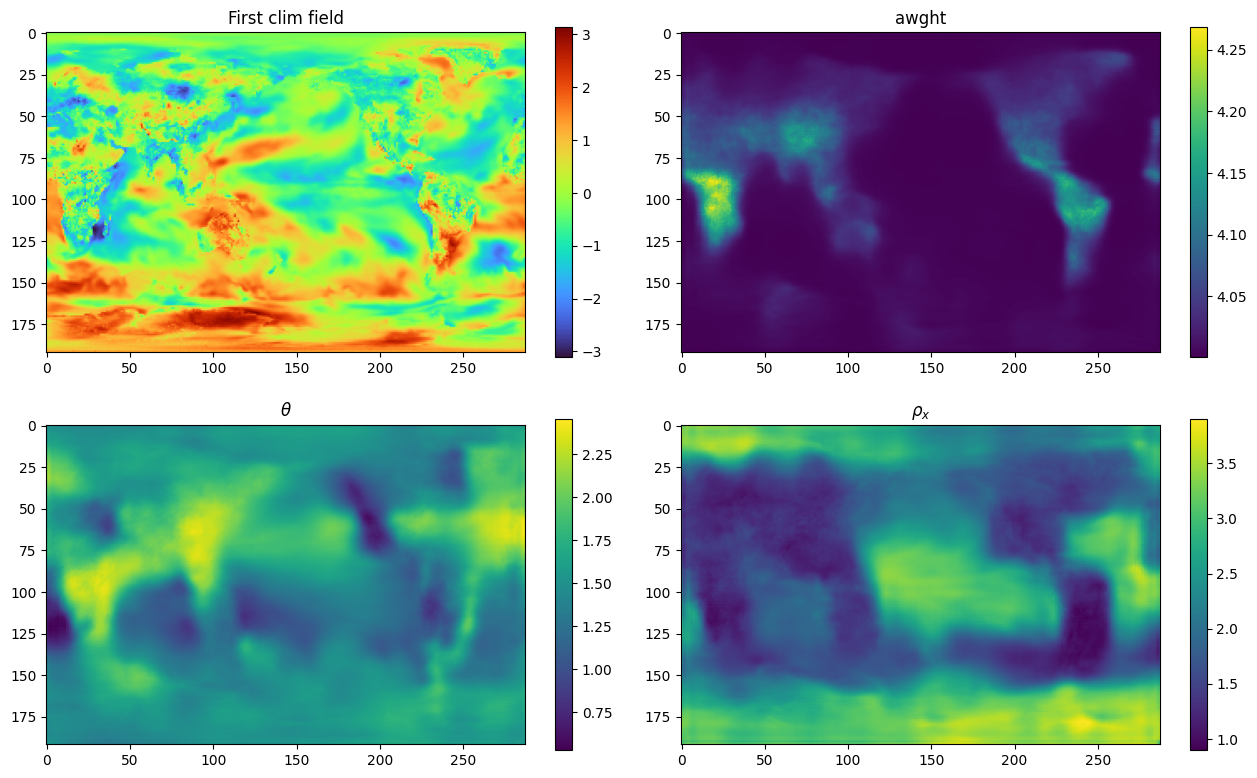

In [7]:
# plot the first original clim field and the outputs (3 channels)
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

ax[0, 0].imshow(clim_field, cmap="turbo")
ax[0, 0].set_title("First clim field")
fig.colorbar(ax[0, 0].imshow(clim_field, cmap="turbo"), ax=ax[0, 0], shrink=0.9)

ax[0, 1].imshow(kappa2, cmap="turbo")
ax[0, 1].set_title("awght")
fig.colorbar(ax[0, 1].imshow(awght, cmap="viridis"), ax=ax[0, 1], shrink=0.9)

ax[1, 0].imshow(theta, cmap="viridis")
ax[1, 0].set_title(r"$\theta$")
fig.colorbar(ax[1, 0].imshow(theta, cmap="viridis"), ax=ax[1, 0], shrink=0.9)

ax[1, 1].imshow(rho, cmap="viridis")
ax[1, 1].set_title(r"$\rho_x$")
fig.colorbar(ax[1, 1].imshow(rho, cmap="viridis"), ax=ax[1, 1], shrink=0.9)
plt.tight_layout()
plt.show()

One can then uncomment the lines below to save the model outputs (parameters):

In [8]:
# final = output.detach().cpu().numpy()
# # remove first dim from final
# final = np.squeeze(final)
# final.shape

In [9]:
# with h5py.File('../sample_data/STUN30rep_clim_output_example.h5', 'w') as f:
#     f.create_dataset('clim_output', data=final)

## Local CNN

We repeat all of the steps above with only minor differences to accomodate the moving window estimation approach with a CNN. 

In [10]:
config = CNNModelConfig(
	sidelen=25,
	in_channels=30,
	out_params=3,
	conv_channels=(64, 128, 256),
	linear_sizes=(500, 64),
	kernel_sizes=(10, 7, 5),
	padding=0,
)

# config = CNNModelConfig(
#     sidelen=17,
# 	in_channels=30,
# 	out_params=3,
# 	conv_channels=(64, 128, 256),
# 	linear_sizes=(500,64),
#     kernel_sizes = (6,4,4),
#     padding = 0,
# )

# config = CNNModelConfig(
#     sidelen=9,
# 	in_channels=1,
# 	out_params=3,
# 	conv_channels=(64, 128, 256),
# 	linear_sizes=(500,64),
#     kernel_sizes = (2,2,2),
#     padding = 0,
# )

model = CNN(config)
state_dict = torch.load(
	"../results/model_wghts/modelCNN_size25_reps30.pth",
	map_location=torch.device(device),
)
model.load_state_dict(state_dict)
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(30, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (3): GELU(approximate='none')
    (4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
    (5): GELU(approximate='none')
  )
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc_layers): Sequential(
    (0): Linear(in_features=2304, out_features=500, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=500, out_features=64, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [11]:
cnn_outputs = torch.zeros(output.size())
cnn_outputs.shape

torch.Size([1, 3, 192, 288])

In [12]:
clim_fields_norm = clim_fields_norm[:, :n_reps, :, :]

In [13]:
for i in range(len(cnn_outputs)):
	print(clim_fields_norm[i].unsqueeze(0).shape)

torch.Size([1, 30, 192, 288])


In [14]:
for i in range(len(cnn_outputs)):
	cnn_output = fast_cnn_field_tiler(
		model=model,
		fields=clim_fields_norm[i].unsqueeze(0),
		device=device,
		patch_batch_size=10000,
		verbose=False,
		padding_mode="reflect",
		patch_size=25,
	)
	cnn_outputs[i] = cnn_output

cnn_outputs.shape

torch.Size([1, 3, 192, 288])

In [15]:
kappa2_cnn = np.flip(cnn_outputs[0, 0, :, :].detach().cpu().numpy(), axis=0)
theta_cnn = np.pi / 2 - np.flip(cnn_outputs[0, 1, :, :].detach().cpu().numpy(), axis=0)
rho_cnn = np.flip(cnn_outputs[0, 2, :, :].detach().cpu().numpy(), axis=0)
awght_cnn = np.exp(kappa2_cnn) + 4
print(
	np.min(awght_cnn),
	np.max(awght_cnn),
	np.min(theta_cnn),
	np.max(theta_cnn),
	np.min(rho_cnn),
	np.max(rho_cnn),
)

4.0001016 4.162983 0.1396991 3.0627313 0.9443765 5.130092


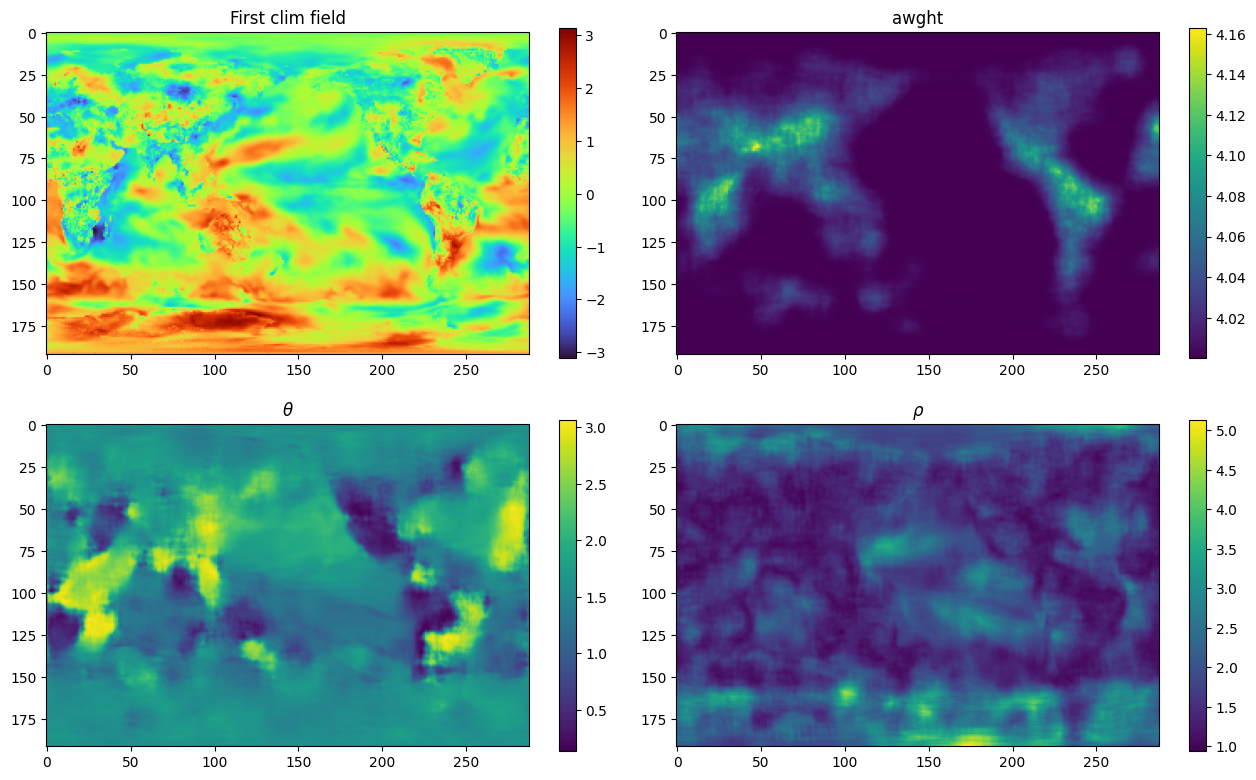

In [16]:
# plot the first original clim field and the outputs (3 channels)
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

ax[0, 0].imshow(clim_field, cmap="turbo")
ax[0, 0].set_title("First clim field")
fig.colorbar(ax[0, 0].imshow(clim_field, cmap="turbo"), ax=ax[0, 0], shrink=0.9)

ax[0, 1].imshow(kappa2_cnn, cmap="turbo")
ax[0, 1].set_title("awght")
fig.colorbar(ax[0, 1].imshow(awght_cnn, cmap="viridis"), ax=ax[0, 1], shrink=0.9)

ax[1, 0].imshow(theta_cnn, cmap="viridis")
ax[1, 0].set_title(r"$\theta$")
fig.colorbar(ax[1, 0].imshow(theta_cnn, cmap="viridis"), ax=ax[1, 0], shrink=0.9)

ax[1, 1].imshow(rho_cnn, cmap="viridis")
ax[1, 1].set_title(r"$\rho$")
fig.colorbar(ax[1, 1].imshow(rho_cnn, cmap="viridis"), ax=ax[1, 1], shrink=0.9)
plt.tight_layout()
plt.show()

Once again, saving is done below. 

In [17]:
# final_cnn = cnn_outputs.detach().cpu().numpy()
# # remove first dim from final
# final_cnn = np.squeeze(final_cnn)
# final_cnn.shape

In [18]:
# with h5py.File('../sample_data/CNN25_clim_output_example.h5', 'w') as f:
#     f.create_dataset('clim_output', data=final_cnn)